# Homework 4 - Titanic

### Kaggle Classification Competition

Here, we use the Kaggle dataset for Titanic survivors. We'll attempt to predict the survival of passengers of the Titanic based on a set of characteristics we know about them. 

### Background

The Titanic was a large, luxury steamship that had its maiden voyage in April of 1912. At one point in its construction, in 1911, its hull was the largest movable man-made object in the world. It is famous for having what was once considered a "practically unsinkable" design, due to a double bottom and watertight bulkhead compartments.  Unfortunately, on April 15th, 1912, the Titanic crashed into an iceberg and sank, resulting in the deaths of 1502 out of the 2224 who were on board at the time. The belief that the ship was "unsinkable" partly led to the large number of deaths - there were not enough lifeboats for everyone to escape on, and many of those on board had no hope of survival (Info from [Kaggle](https://www.kaggle.com/c/titanic), [History](https://www.history.com/topics/titanic)).

Since over half of the passengers and crew did not survive this accident, we have a large dataset of binary variables - 1 for a survivor, and 0 for someone who went down with the ship. Certain groups tended to survive more than others, such as women and children, as well as higher-class people. In addition to this "survival" variable, we have a set of other information about the passengers, such as their names, ticket number, and fare paid. We'll see how well we can (retroactively) predict the survival of a subset of the passengers on the ship.

First, we'll load in the data we need for this project, along with libraries and packages that will come in handy:

### Preparation

##### Packages, Libraries, and Options:

In [1]:
# Import useful tools
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import math
import sklearn
import missingno as msno

# Set settings for notebook
sns.set(style='ticks', palette='Set2')
%matplotlib inline
plt.style.use('seaborn')
pd.set_option('display.max_columns', 50)

##### Data:

First we read in the training dataset:

In [2]:
train_df = pd.read_csv('train.csv')
print(train_df.shape)
train_df.head()

(891, 12)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


We need to separate our "Y variable", survival, from the rest for use in prediction. We'll do that here:

In [3]:
# Separate outcome variable
y_train = train_df['Survived']

# Remove outcome variable from training data (to avoid extreme overfitting)
train_data = train_df.drop('Survived', axis = 1)

Now we read in the testing dataset, as well:

In [4]:
test_data = pd.read_csv('test.csv')
print(test_data.shape)
test_data.head()

(418, 11)


,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


Perfect! We see that the datasets are very similar, with the only instantly noticeable difference being that the testing dataset has no data for survival (this makes perfect sense, since we are trying to predict survival). We can only see the first few rows of our data, but there already seem to be at least some issues with missing values and different types of entries. We'll proceed to the data-cleaning step now.

## Cleaning

We need to make sure our training and testing datasets are similarly structured, so as we go through each step, we'll perform each data-cleaning step on both datasets. We do this separately (rather than combining the two datasets) to ensure that our training data doesn't change our testing data unnecessarily.

##### Missing Data:

We'll start by seeing which variables might have missing values:

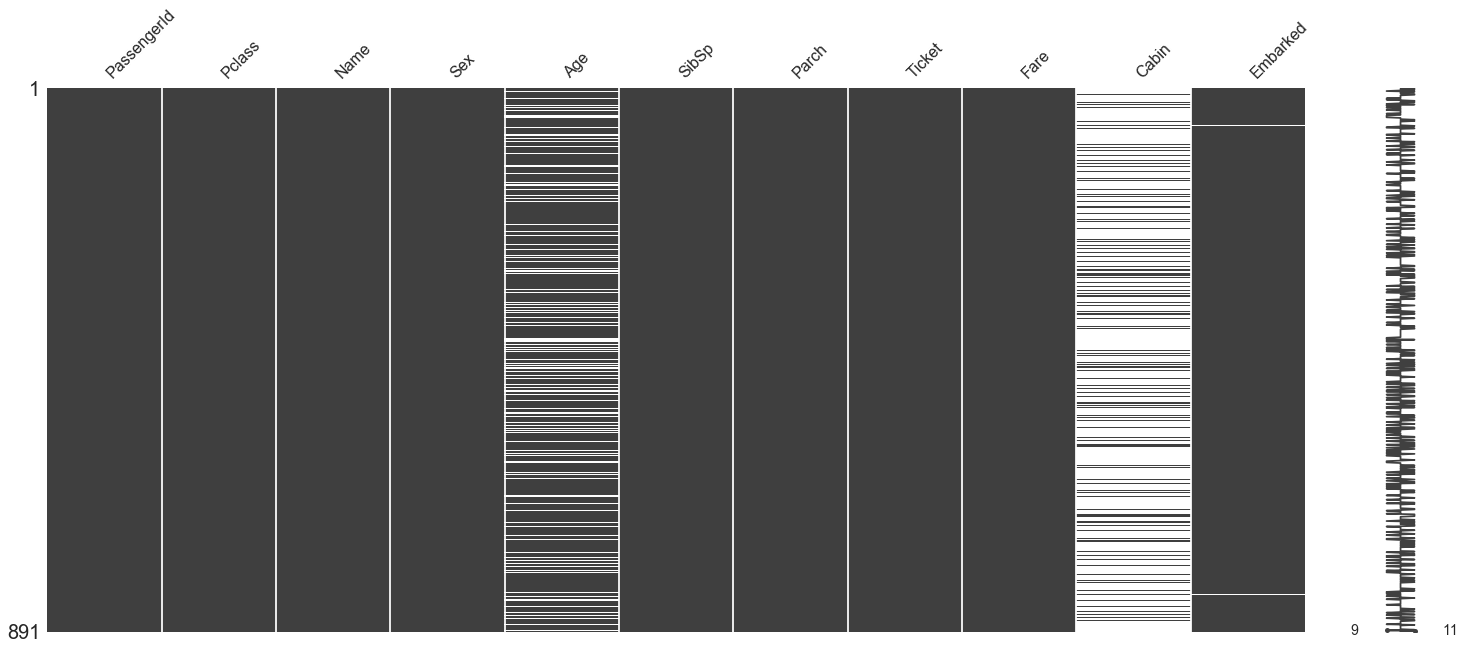

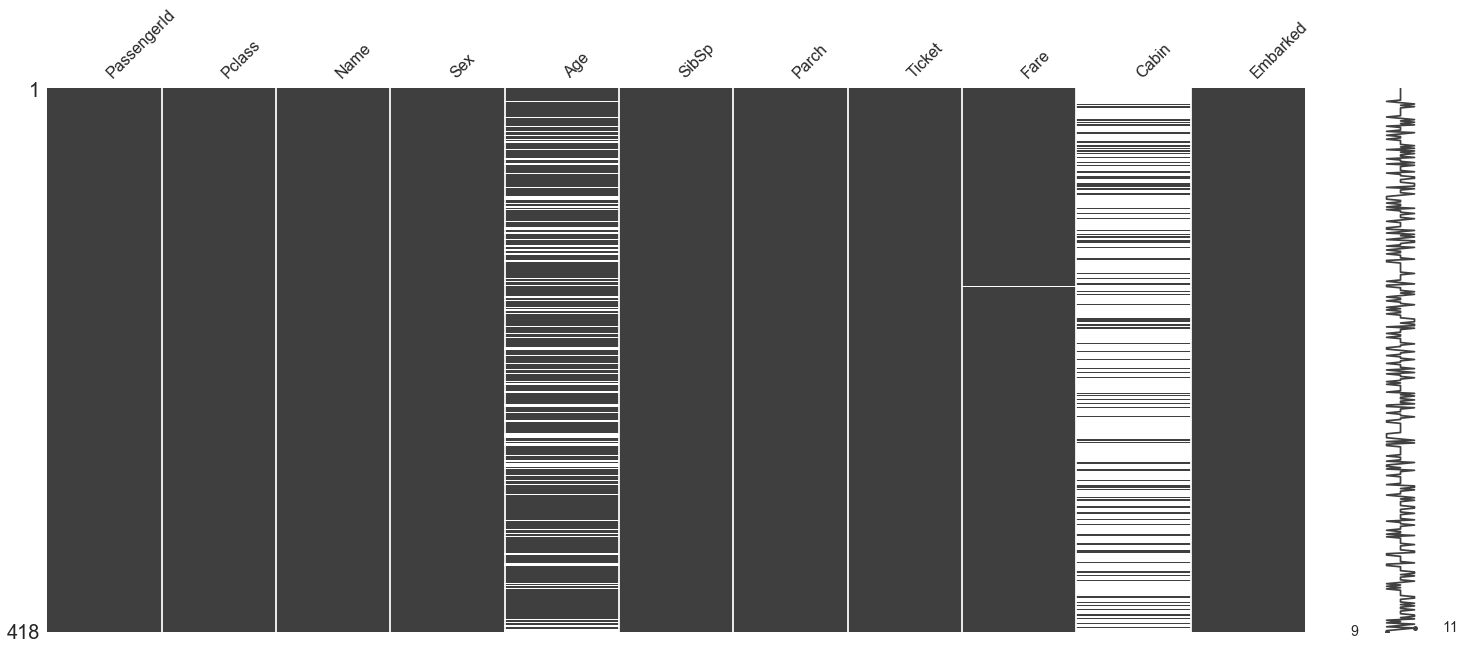

In [5]:
msno.matrix(train_data)
msno.matrix(test_data)

Most of our columns appear to have no missing values, but there are a few in each dataset (most notably, "age" and "cabin") that have several. We'll look into this a little more:

In [6]:
train_data.columns[train_data.isnull().any()]

Index(['Age', 'Cabin', 'Embarked'], dtype='object')

In [7]:
test_data.columns[test_data.isnull().any()]

Index(['Age', 'Fare', 'Cabin'], dtype='object')

"Age" and "cabin" are both missing quite a bit of data for both datasets, so we'll have to do something about that. We can also see that there are some other missing values - "embarked" for the training dataset, and "fare" for the test dataset. We'll look into any patterns in which data is missing.

First, as we can see below, the "embarked" and "fare" columns are only missing a few rows for each dataset. They have the same ticket number and paid the same fare, which is odd, but that may be because they were in the same cabin, and that's how tickets were done back then. Regardless, there are only two passengers, which won't impact our data much. Later on, we'll be making dummy variables for each departure point, and these two will just have 0 for all three possible departure point (which is what the "embarked" variable is for).

In [8]:
train_data[train_data['Embarked'].isnull()]

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
61,62,1,"Icard, Miss. Amelie",female,38.0,0,0,113572,80.0,B28,NaN
829,830,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62.0,0,0,113572,80.0,B28,NaN


This next passenger has no fare data, which might be more of a problem. However, we can see that he is in the lower class of passengers.

In [9]:
test_data[test_data['Fare'].isnull()]

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
152,1044,3,"Storey, Mr. Thomas",male,60.5,0,0,3701,NaN,NaN,S


Before deciding what to do, we'll check the distribution of fares in the training dataset (just to get an idea of what it should look like in the testing dataset):

Text(0.5,0,'Fares')

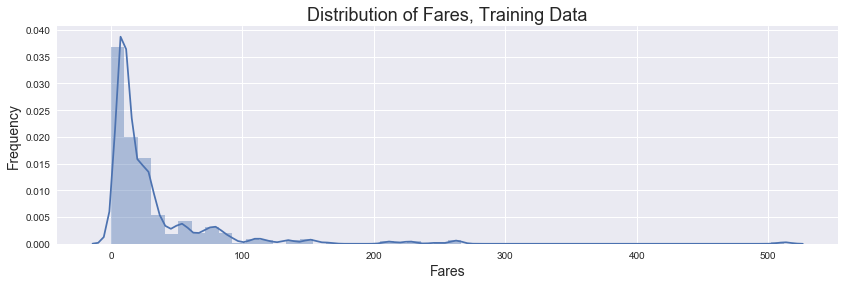

In [10]:
f, ax = plt.subplots(figsize = (14,4))
ax.set_title("Distribution of Fares, Training Data", fontsize = 18)
sns.distplot(train_data['Fare'], ax = ax)
plt.ylabel("Frequency", fontsize = 14)
plt.xlabel("Fares", fontsize = 14)

We can probably expect the fare distribution for the test dataset to be similar - we'll go ahead and replace this missing fare value with the median value for the training set's fares, and we'll check the distribution after we do that:

Text(0.5,0,'Fares')

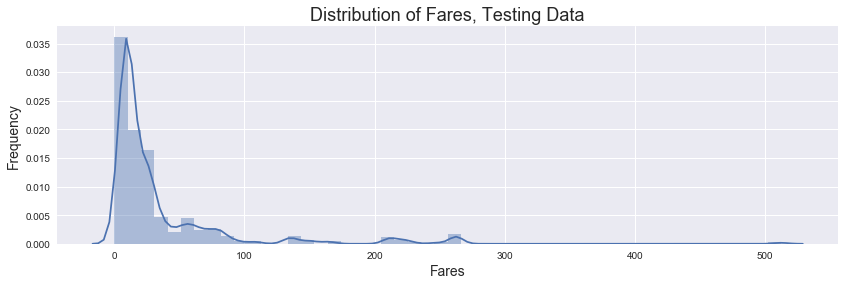

In [11]:
# Fill in missing values with median fare data
values = {'Fare': train_data['Fare'].median()}
test_data = test_data.fillna(value = values)

f, ax = plt.subplots(figsize = (14,4))
ax.set_title("Distribution of Fares, Testing Data", fontsize = 18)
sns.distplot(test_data['Fare'], ax = ax)
plt.ylabel("Frequency", fontsize = 14)
plt.xlabel("Fares", fontsize = 14)

Perfect! The distribution is similar, so it looks like choosing the median was the right thing to do (it will be closer to the bottom, since this is approximately log-normally distributed).

Now that we've taken care of the smaller issues, we'll take a look at the "cabin" and "age" variables. We might suspect that the ship's logs aren't as great for those in the lower classes. We'll check to see if that's true (remember - a 3 stands for the lowest class passenger).

First we look at the Age variable:

In [12]:
pd.DataFrame(train_data[train_data['Age'].isnull()]['Pclass']).describe()

,Pclass
count,177.000000
mean,2.598870
std,0.763216
min,1.000000
25%,3.000000
50%,3.000000
75%,3.000000
max,3.000000


As suspected, we see more missing values among the lower-class passengers (at least 50% of all of the missing values for these variables are for lower-class passengers). We'll check how age distributions vary between upper and lower-class passengers:

In [13]:
pd.DataFrame(train_data[train_data['Pclass'] == 3]['Age']).describe()

,Age
count,355.000000
mean,25.140620
std,12.495398
min,0.420000
25%,18.000000
50%,24.000000
75%,32.000000
max,74.000000


In [14]:
pd.DataFrame(train_data[train_data['Pclass'] == 1]['Age']).describe()

,Age
count,186.000000
mean,38.233441
std,14.802856
min,0.920000
25%,27.000000
50%,37.000000
75%,49.000000
max,80.000000


Average age actually varies a bit across classes - as we see below, the lower-class passengers are an average of 13 years younger than the higher-class passengers. Since most of the missing ages are for 3rd-class passengers, we'll replace their age with the 3rd-class average age. We'll do that after looking at the cabin variable:

In [15]:
pd.DataFrame(train_data[train_data['Cabin'].isnull()]['Pclass']).describe()

,Pclass
count,687.000000
mean,2.639010
std,0.589602
min,1.000000
25%,2.000000
50%,3.000000
75%,3.000000
max,3.000000


It looks like even more of those missing a cabin value were in the lower-class passenger group. To avoid over-fitting the data (and since cabin group is easier to group by than number), we'll drop the cabin number and just keep the letter.

In [16]:
# Isolate cabin letters
train_data['CabinLetter'] = train_data.Cabin.str[:1]
train_data = train_data.drop('Cabin', 1)

test_data['CabinLetter'] = test_data.Cabin.str[:1]
test_data = test_data.drop('Cabin', 1)

We'll replace the "cabin letter" value with "N" for "no cabin" (it's not already a value). We can replace missing age now, too:

In [17]:
print(pd.DataFrame(test_data[test_data['Pclass'] == 3]['Age']).mean())
print("")
print(pd.DataFrame(train_data[train_data['Pclass'] == 3]['Age']).mean())

Age    24.027945
dtype: float64

Age    25.14062
dtype: float64


In [18]:
# Replace missing values with mean age for 3rd-class passengers
test_data['CabinLetter'] = test_data.CabinLetter.str[:1]
values = {'CabinLetter': "N", 'Age': 24.028}
test_data = test_data.fillna(value = values)

train_data['CabinLetter'] = train_data.CabinLetter.str[:1]
values = {'CabinLetter': "N", 'Age': 25.141}
train_data = train_data.fillna(value = values)

Now we'll check once more for missing values:

In [19]:
test_data.columns[test_data.isnull().any()]

Index([], dtype='object')

In [20]:
train_data.columns[train_data.isnull().any()]

Index(['Embarked'], dtype='object')

Perfect! Now our only missing values are for "embarked" in the training dataset (which, as we've already mentioned, is ok - there are only two entries with missing values, and we'll just use dummy variables to control for this effect).

##### Cleaning:

We want to make a few new variables. This will require splitting a few string variables into pieces to get what's important. For example, the "cabin" variable might help us understand more info about the person's status or proximity to a lifeboat, so we'll just take the first letter of this variable (when it exists) to indicate which group of cabins that person was staying in. Even for those who have no cabin information, we can just replace this value with "N" (for "no cabin information").

We'll also split up the name to retrieve the title, such as "Mr.", "Reverend", "Doctor", or "Ms.", since certain classes of people may have had priority over others. We'll then drop our unnecessary variables and see how the data looks:

In [21]:
# Separate first word from the rest of the name
train_data['first'], train_data['titlefirsts'] = train_data['Name'].str.split(', ', 1).str

# Separate title from the first names
train_data['Title'], train_data['firsts'] = train_data['titlefirsts'].str.split(' ', 1).str

# Drop unnecessary variables
to_drop = ['Name', 'titlefirsts', 'first', 'firsts']
train_data = train_data.drop(to_drop, 1)
train_data.head()

,PassengerId,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,CabinLetter,Title
0,1,3,male,22.0,1,0,A/5 21171,7.2500,S,N,Mr.
1,2,1,female,38.0,1,0,PC 17599,71.2833,C,C,Mrs.
2,3,3,female,26.0,0,0,STON/O2. 3101282,7.9250,S,N,Miss.
3,4,1,female,35.0,1,0,113803,53.1000,S,C,Mrs.
4,5,3,male,35.0,0,0,373450,8.0500,S,N,Mr.


We'll do the same for the testing data:

In [22]:
# Separate first word from the rest of the name
test_data['first'], test_data['titlefirsts'] = test_data['Name'].str.split(', ', 1).str

# Separate title from the first names
test_data['Title'], test_data['firsts'] = test_data['titlefirsts'].str.split(' ', 1).str

# Drop unnecessary variables
to_drop = ['Name', 'titlefirsts', 'first', 'firsts']
test_data = test_data.drop(to_drop, 1)
test_data.head()

,PassengerId,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,CabinLetter,Title
0,892,3,male,34.5,0,0,330911,7.8292,Q,N,Mr.
1,893,3,female,47.0,1,0,363272,7.0000,S,N,Mrs.
2,894,2,male,62.0,0,0,240276,9.6875,Q,N,Mr.
3,895,3,male,27.0,0,0,315154,8.6625,S,N,Mr.
4,896,3,female,22.0,1,1,3101298,12.2875,S,N,Mrs.


We'll now pull the ticket number from the ticket column - it's a bit complicated, since there are sometimes letters and symbols used here:

In [23]:
# Separate ticket variable 
test_data['TickL1'], test_data['TickL2'], test_data['TicketNum'] = test_data['Ticket'].str.split(' ', 2).str

# Fill in missing ticket numbers with columns containing only the numbers 
#    (there are two columns because of the formatting of the data)
values = {'TicketNum': test_data['TickL2']}
test_data = test_data.fillna(value = values)
values = {'TicketNum': test_data['TickL1']}
test_data = test_data.fillna(value = values)

# Drop unnecessary variables and change ticket number from string to integer
test_data = test_data.drop(['TickL1', 'TickL2', 'Ticket'], 1)
test_data['TicketNum'] = test_data['TicketNum'].apply(pd.to_numeric)

We'll do the same thing for the training data, although we need to make one edit (the second to last line) for a troublesome bit of data. We'll replace the value with 300000, since many other 3rd-class passengers have ticket numbers around this (this is a case-specific fix).

In [24]:
# We follow the same process as above
train_data['TickL1'], train_data['TickL2'], train_data['TicketNum'] = train_data['Ticket'].str.split(' ', 2).str
values = {'TicketNum': train_data['TickL2']}
train_data = train_data.fillna(value = values)
values = {'TicketNum': train_data['TickL1']}
train_data = train_data.fillna(value = values)
train_data = train_data.drop(['TickL1', 'TickL2', 'Ticket'], 1)
train_data['TicketNum'] = np.where(train_data['TicketNum'] == "LINE", 300000, train_data['TicketNum'])
train_data['TicketNum'] = train_data['TicketNum'].apply(pd.to_numeric)

##### Dummy Variables:

We can see that we have a few string variables that we'd like to turn into numerical dummy variables - we'll do that now:

In [25]:
# Variable list to convert into dummy variables
to_dummies = ['Sex', 'Embarked', 'CabinLetter', 'Title']

# Loop through the list to create dummy variables for both dataframes
for var in to_dummies:
    tempdat = pd.get_dummies(train_data[var], prefix = var)
    train_data = pd.concat([train_data, tempdat], axis = 1)
    
    tempdat = pd.get_dummies(test_data[var], prefix = var)
    test_data = pd.concat([test_data, tempdat], axis = 1)
    
# Drop unnecessary variables
train_data = train_data.drop(to_dummies, 1)
test_data = test_data.drop(to_dummies, 1)

Now we just need to make sure our training and testing data have the same dimensions. We'll check the lists now:

In [26]:
print(train_data.columns)
print("")
print(test_data.columns)

Index(['PassengerId', 'Pclass', 'Age', 'SibSp', 'Parch', 'Fare', 'TicketNum',
       'Sex_female', 'Sex_male', 'Embarked_C', 'Embarked_Q', 'Embarked_S',
       'CabinLetter_A', 'CabinLetter_B', 'CabinLetter_C', 'CabinLetter_D',
       'CabinLetter_E', 'CabinLetter_F', 'CabinLetter_G', 'CabinLetter_N',
       'CabinLetter_T', 'Title_Capt.', 'Title_Col.', 'Title_Don.', 'Title_Dr.',
       'Title_Jonkheer.', 'Title_Lady.', 'Title_Major.', 'Title_Master.',
       'Title_Miss.', 'Title_Mlle.', 'Title_Mme.', 'Title_Mr.', 'Title_Mrs.',
       'Title_Ms.', 'Title_Rev.', 'Title_Sir.', 'Title_the'],
      dtype='object')

Index(['PassengerId', 'Pclass', 'Age', 'SibSp', 'Parch', 'Fare', 'TicketNum',
       'Sex_female', 'Sex_male', 'Embarked_C', 'Embarked_Q', 'Embarked_S',
       'CabinLetter_A', 'CabinLetter_B', 'CabinLetter_C', 'CabinLetter_D',
       'CabinLetter_E', 'CabinLetter_F', 'CabinLetter_G', 'CabinLetter_N',
       'Title_Col.', 'Title_Dona.', 'Title_Dr.', 'Title_Master.',
       'Tit

We've got a couple differences - we'll drop all of the variables that only appear in one dataset to prevent any problems. By examining the data, we see that a few of the variables we've created only apply to a couple of the passengers. "Title_Jonkheer" is a good example of this, since it is an uncommon honorific term that apparently applies to only one of the passengers in the training data.

In [27]:
# Drop variables that only appear in one dataset
train_data = train_data.drop(['CabinLetter_T', 'Title_Capt.', 'Title_Don.', 'Title_Jonkheer.', 'Title_Lady.',
                              'Title_Major.', 'Title_Mlle.', 'Title_Mme.', 'Title_Sir.', 'Title_the'], 1)
test_data = test_data.drop(['Title_Dona.'], 1)

# Print column names again to make sure they match
print(train_data.columns)
print("")
print(test_data.columns)

Index(['PassengerId', 'Pclass', 'Age', 'SibSp', 'Parch', 'Fare', 'TicketNum',
       'Sex_female', 'Sex_male', 'Embarked_C', 'Embarked_Q', 'Embarked_S',
       'CabinLetter_A', 'CabinLetter_B', 'CabinLetter_C', 'CabinLetter_D',
       'CabinLetter_E', 'CabinLetter_F', 'CabinLetter_G', 'CabinLetter_N',
       'Title_Col.', 'Title_Dr.', 'Title_Master.', 'Title_Miss.', 'Title_Mr.',
       'Title_Mrs.', 'Title_Ms.', 'Title_Rev.'],
      dtype='object')

Index(['PassengerId', 'Pclass', 'Age', 'SibSp', 'Parch', 'Fare', 'TicketNum',
       'Sex_female', 'Sex_male', 'Embarked_C', 'Embarked_Q', 'Embarked_S',
       'CabinLetter_A', 'CabinLetter_B', 'CabinLetter_C', 'CabinLetter_D',
       'CabinLetter_E', 'CabinLetter_F', 'CabinLetter_G', 'CabinLetter_N',
       'Title_Col.', 'Title_Dr.', 'Title_Master.', 'Title_Miss.', 'Title_Mr.',
       'Title_Mrs.', 'Title_Ms.', 'Title_Rev.'],
      dtype='object')


Perfect! We've got everything just how we want it for our analysis. Now we'll visualize a bit of the data so we can understand it.

## Visualization

We've already looked a little bit at age and fare distribution. Let's take a look at the training dataset again to use some of the categories there (it'll be easier for our graphs to use it instead of the new, cleaned dataset). We'll make a few edits and then start to look at some charts.

First, we'll make age buckets with 6-year intervals, where the value for "AgeBin" is the largest multiple of 6 less than or equal to the person's age. Then repeat our creation of the cabin group dummy variables. Finally, we'll create a title variable.

In [28]:
# Create age buckets
train_df['AgeBin'] = train_df['Age'] / .6
train_df['AgeBin'] = np.round(train_df['AgeBin'], -1)
train_df['AgeBin'] = train_df['AgeBin'] * .6

# Replace missing cabin letters with N (and create cabin letter variable)
train_df['CabinL'] = train_df.Cabin.str[:1]
values = {'CabinL': "N"}
train_df = train_df.fillna(value = values)

# Retrieve titles from name variable, discard unnecessary information
train_df['first'], train_df['titlefirsts'] = train_df['Name'].str.split(', ', 1).str
train_df['Title'], train_df['firsts'] = train_df['titlefirsts'].str.split(' ', 1).str
to_drop = ['Name', 'titlefirsts', 'first', 'firsts']
train_df = train_df.drop(to_drop, 1)

Now that we have our new variables, we can look at how survival varies by group. In our first graph, we'll examine average survival rates for men and women, across their age buckets.

Text(0.5,0,'Sex')

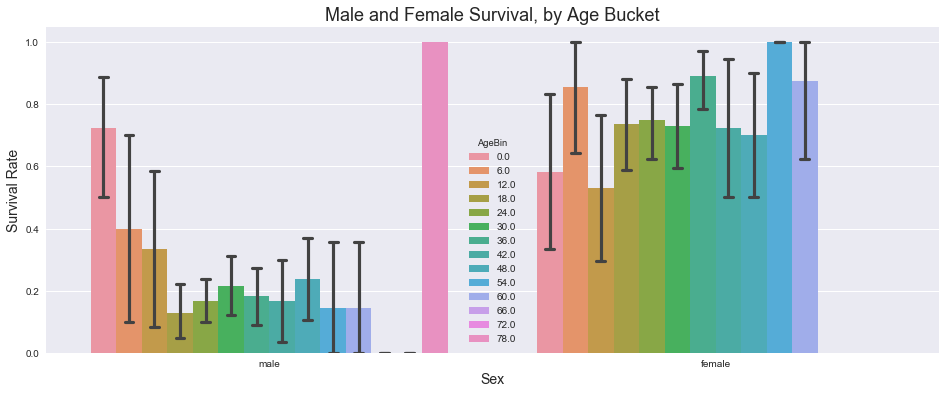

In [29]:
f, ax = plt.subplots(figsize = (16,6))
ax.set_title("Male and Female Survival, by Age Bucket", fontsize = 18)
sns.barplot(x="Sex", y="Survived", hue = "AgeBin", data=train_df, ax = ax, capsize=.02)
plt.ylabel("Survival Rate", fontsize = 14)
plt.xlabel("Sex", fontsize = 14)

We can tell that although men and women have different survival rates across the board, these survival rates depend significantly on the age of the passengers. Over half of the young boys in the training dataset survived, which is a stark difference from those just a decade or two older.

Next, we will examine how survival rates varied by cabin group. Remember that we assigned the group "N" to those who were missing cabin data, and that the other letters came from the cabin variable provided.

Text(0.5,0,'Cabin Group')

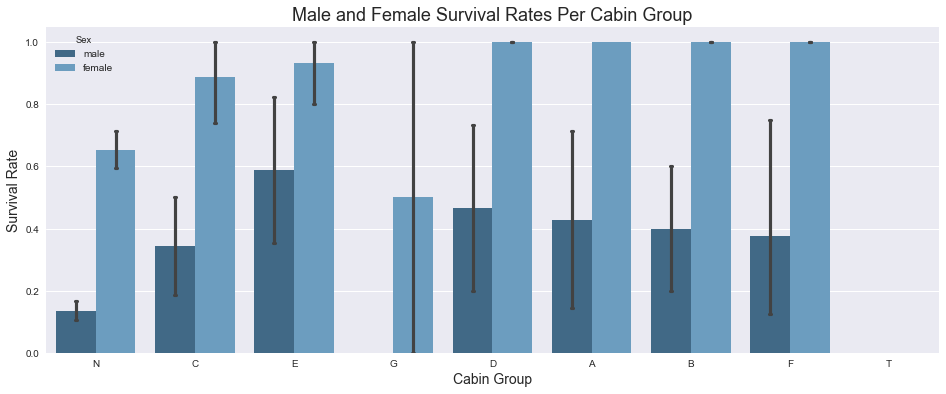

In [30]:
f, ax = plt.subplots(figsize = (16,6))
ax.set_title("Male and Female Survival Rates Per Cabin Group", fontsize = 18)
sns.barplot(x="CabinL", y="Survived", hue="Sex", data=train_df, ax = ax, capsize=.02, palette="Blues_d")
plt.ylabel("Survival Rate", fontsize = 14)
plt.xlabel("Cabin Group", fontsize = 14)

Again, women survived much more frequently. It is interesting to note that although there was less variance in female survival rates by cabin, male survival seems to depend much more on the cabin group.

Finally, we'll examine the graph of survival rate by titles. This is perhaps the most valuable information we can gather from the name variable.

Text(0.5,0,'Title')

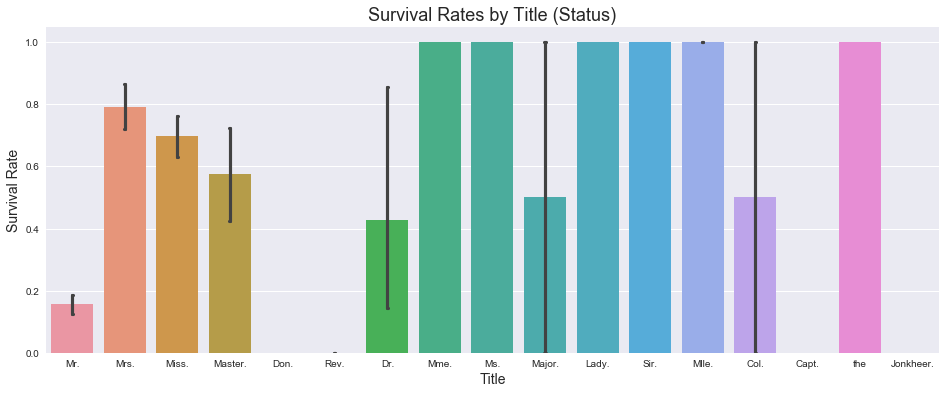

In [31]:
f, ax = plt.subplots(figsize = (16,6))
ax.set_title("Survival Rates by Title (Status)", fontsize = 18)
sns.barplot(x="Title", y="Survived", data=train_df, ax = ax, capsize = .02)
plt.ylabel("Survival Rate", fontsize = 14)
plt.xlabel("Title", fontsize = 14)

Some titles had perfect survival rate - this is most likely due to a very small number of survivors having that title. The interesting part comes from the more common titles, such as "Mr.", "Mrs.", and "Dr.", all of which had different survival rates.

This is interesting, but it is difficult to look at graphs and accurately predict survival. That leads us to the next step - modeling survival rates.

## Modeling

We'll now start the modeling process. First, we import the packages we'll need for this section:

In [32]:
# Import modeling tools
from sklearn.model_selection import GridSearchCV as GSCV
from sklearn.linear_model import LogisticRegressionCV as logitcv
from sklearn.metrics import accuracy_score as AS
from sklearn.metrics import confusion_matrix as CM
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier as entmoot
from sklearn.neighbors import KNeighborsClassifier as KNC
from sklearn.ensemble import GradientBoostingClassifier as GBC
from sklearn.metrics import classification_report as CR

### Logistic Regression

We'll start with a simple logistic regression. This has the advantage of being easy to understand - whatever coefficients we receive from our model, we can exponentiate to get an approximate effect of having a certain characteristic (for example, a 30% increase in expected survival if someone is under 12 years old).

In [33]:
# Set up cross-validation for logistic regression
lcv = logitcv(tol=.00000001, cv = 5, Cs=[1, .1, .01, .001, .0001], 
            solver='liblinear', scoring='accuracy')

Now we'll fit the model and predict on our training data:

In [34]:
lcv.fit(train_data, y_train)
y_pred_lcv = lcv.predict(train_data)

We'll now print out the accuracy score, confusion matrix, and classification report to see how we did:

In [35]:
print("\nAccuracy Score:")
print(AS(y_pred_lcv, y_train))
print("\nConfusion Matrix:")
print(CM(y_pred_lcv, y_train))
print("\nClassification Report:")
print(CR(y_pred_lcv, y_train))


Accuracy Score:
0.835016835017

Confusion Matrix:
[[481  79]
 [ 68 263]]

Classification Report:
             precision    recall  f1-score   support

          0       0.88      0.86      0.87       560
          1       0.77      0.79      0.78       331

avg / total       0.84      0.84      0.84       891



As previously mentioned, one advantage of the logistic model is that we get a good understanding of how each feature impacts the probability of survival. We'll take a look below:

Text(0,0.5,'Important Factors')

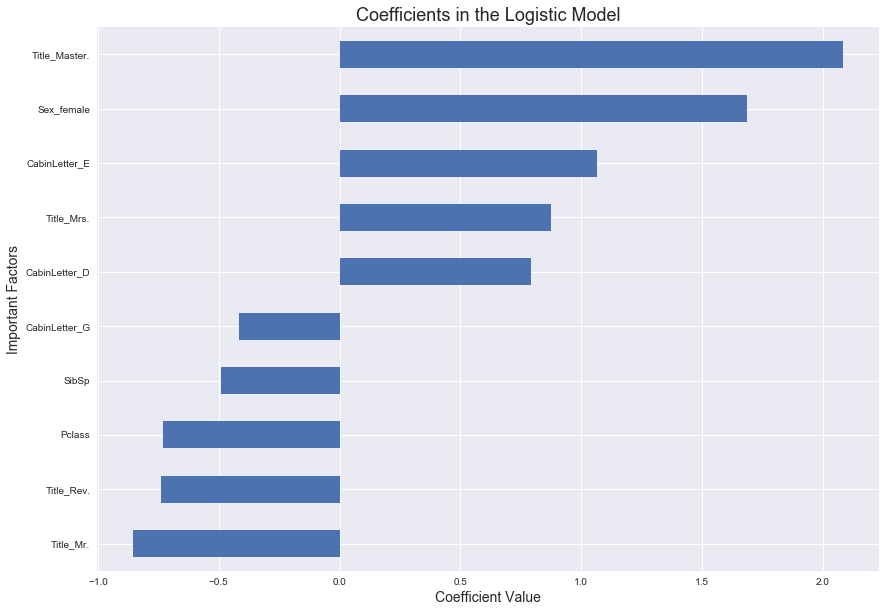

In [36]:
# Pull important coefficients
coef = pd.Series(lcv.coef_[0], index = train_data.columns)
important_coef = pd.concat([coef.sort_values().head(5), coef.sort_values().tail(5)])

# Graph coefficient values
mpl.rcParams['figure.figsize'] = (14.0, 10.0)
important_coef.plot(kind = "barh")
plt.title("Coefficients in the Logistic Model", fontsize = 18)
plt.xlabel("Coefficient Value", fontsize = 14)
plt.ylabel("Important Factors", fontsize = 14)

We see a lot of the same patterns that appeared during visualization - the men tended to survive less than the women, although young boys had a high survival rate. Certain cabins fared better than others, and chances of survival diminished with passenger class.

We can now predict values for our test data:

In [37]:
test_pred_lcv = lcv.predict(test_data)
ps3_submit = pd.DataFrame({'PassengerId': test_data.PassengerId, 'Survived': test_pred_lcv})
ps3_submit.to_csv('titanic_lcv.csv', index=False)

### K Nearest Neighbors

We'll now try to use K Nearest Neighbors to predict survival on our training dataset. K nearest neighbors is a process that looks at the most similar, or "nearest", data points around each individual value and uses voting to classify each person as having survived or passed away. Since there are a few hyperparameters that could be used (the number of neighbors to "poll", the types of weights to use, and the metric used in evaluation), we'll use a Grid Search and cross-validation to test several hyperparameters and avoid overfitting as best as possible.

We've already imported the code, so we'll begin:

In [38]:
knc = KNC()

# Set up grid search for parameters, cross-validation on 5 folds
gscv = GSCV(knc, {"n_neighbors": [1, 3, 5, 7, 9], "weights": ['uniform', 'distance'], 
                                'p': [1, 2, 3]}, scoring='neg_mean_squared_error', cv = 5)

# Fit data
gscv.fit(train_data, y_train)

# Predict target values
y_pred_k = gscv.predict(train_data)

Now let's see what percent of the data we correctly predicted:

In [39]:
print("\nAccuracy Score:")
print(AS(y_pred_k, y_train))
print("\nConfusion Matrix:")
print(CM(y_pred_k, y_train))
print("\nClassification Report:")
print(CR(y_pred_k, y_train))


Accuracy Score:
1.0

Confusion Matrix:
[[549   0]
 [  0 342]]

Classification Report:
             precision    recall  f1-score   support

          0       1.00      1.00      1.00       549
          1       1.00      1.00      1.00       342

avg / total       1.00      1.00      1.00       891



Our model predicted everything 100% correct, so it would seem that our model is overfitting the data. However, we are using cross-validation, so we've made an effort to not overfit too much.

We'll go ahead and predict survival for our test data:

In [40]:
test_pred_k = gscv.predict(test_data)
ps3_submit = pd.DataFrame({'PassengerId': test_data.PassengerId, 'Survived': test_pred_k})
ps3_submit.to_csv('titanic_k.csv', index=False)

### Random Forest

A random forest makes use of decision trees - the algorithm uses Gini impurity scores to determine "splitting points" or nodes where the data can be sorted into the purest class groups possible. The tree "grows" and adds more nodes, sorting data by passing it through the branches of the tree, until it arrives at a leaf node. Upon arriving at the leaf node, it is then classified as belonging to a certain group.

Decision trees are combined in a random forest, when different decision trees are trained on distinct subsets and features of the dataset. This allows the combined "forest" to receive votes from several different models, which have been separated in order to reduce the variance of the model.

In [41]:
# List of possible estimator numbers
n_est = [1000, 2000, 3000]

# List of possible maximum depths for the trees
max_depth = [1, 2, 3, 5]

# List of possible class weights, and beginning value for accuracy
class_weights = ['balanced', 'balanced_subsample', None]
best_acc = 0

# Grid search
for est in n_est:
    for depth in max_depth:
        for wgt in class_weights:
            ents = entmoot(n_estimators=est, max_depth=depth, oob_score=True, class_weight=wgt)
            ents.fit(train_data, y_train)
            acc = AS(y_train, np.argmax(ents.oob_decision_function_ , 1))
            
            # Update best parameter list if the latest model is best
            if acc > best_acc:
                best_acc = acc
                best_params = (est, depth, wgt)

# Fit model based on the best parameters, as found by the model
ents = entmoot(n_estimators=best_params[0], max_depth=best_params[1], class_weight=best_params[2])
ents.fit(train_data, y_train)

RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=5, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=1000, n_jobs=1, oob_score=False,
            random_state=None, verbose=0, warm_start=False)

Now we'll use the best parameters, as found above, to predict our target values. We'll then see our accuracy:

In [42]:
# Predict values
y_pred_ents = ents.predict(train_data)

# Report model performance
print("\nAccuracy Score:")
print(AS(y_pred_k, y_train))
print("\nConfusion Matrix:")
print(CM(y_pred_k, y_train))
print("\nClassification Report:")
print(CR(y_pred_k, y_train))


Accuracy Score:
1.0

Confusion Matrix:
[[549   0]
 [  0 342]]

Classification Report:
             precision    recall  f1-score   support

          0       1.00      1.00      1.00       549
          1       1.00      1.00      1.00       342

avg / total       1.00      1.00      1.00       891



Again, we see we have 100% accuracy. We'll have to see how well this model does in the Kaggle competition - we'll predict these test values right here.

In [43]:
test_pred_ents = ents.predict(test_data)
ps3_submit = pd.DataFrame({'PassengerId': test_data.PassengerId, 'Survived': test_pred_ents})
ps3_submit.to_csv('titanic_ents.csv', index=False)

### Gradient Boosting

Boosting is another method, in which successive models are trained to overcome the weaknesses of their predecessors. Gradient boosting, which we will now use, incorporates decision trees and trains them (after the first one) to predict the residual values. These other trees' predictions are summed with the first to make a total prediction for each variable, with the hope that combining models in this way will predict all values well without overfitting.

We'll use a grid search to try out a few different hyperparameters, as we've done before:

In [44]:
# Set up model
gbc = GBC()
gscv = GSCV(gbc, {"learning_rate": [.1, .01, .001, .0001,], "n_estimators": [100, 250, 500],
                                'max_depth': [1, 3, 5]}, scoring='accuracy', cv = 5)

# Fit model
gscv.fit(train_data, y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'learning_rate': [0.1, 0.01, 0.001, 0.0001], 'n_estimators': [100, 250, 500], 'max_depth': [1, 3, 5]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=0)

Now that we've fit the model, we can see how our model performs on the training dataset.

In [45]:
# Predict values
y_pred_boost = gscv.predict(train_data)

# Report on model performance
print("\nAccuracy Score:")
print(AS(y_pred_k, y_train))
print("\nConfusion Matrix:")
print(CM(y_pred_k, y_train))
print("\nClassification Report:")
print(CR(y_pred_k, y_train))


Accuracy Score:
1.0

Confusion Matrix:
[[549   0]
 [  0 342]]

Classification Report:
             precision    recall  f1-score   support

          0       1.00      1.00      1.00       549
          1       1.00      1.00      1.00       342

avg / total       1.00      1.00      1.00       891



Again, there seems to be overfitting, even with cross-validation. We'll now use our model to predict survival for the testing dataset:

In [46]:
test_pred_boost = gscv.predict(test_data)
ps3_submit = pd.DataFrame({'PassengerId': test_data.PassengerId, 'Survived': test_pred_boost})
ps3_submit.to_csv('titanic_boost.csv', index=False)

### Conclusions

We've been able to test out a few different models. Some appear to have over-fit the data, even when making efforts to cross-validate and control for that. 

It is interesting to note that, at least in the case of the logistic regression, we were able to see which values would be important just from looking at the graph. However, this model wasn't perfect, and it would be much harder to predict each individual's survival without the use of these models.

There were fewer features provided in this dataset than in others (for example, the housing prices dataset). However, even with a relatively small amount of information, near-accurate prediction is still possible. It's always better to have some data and some idea than to rely on guessing and intuition.